# Lab 4: Data Imputation using an Autoencoder

**Deadline**: Thursday, Nov 5, 11:59pm

**Late Penalty**: There is a penalty-free grace period of one hour past the deadline. Any work that is submitted between 1 hour and 24 hours past the deadline will receive a 20% grade deduction. No other late work is accepted. Quercus submission time will be used, not your local computer time. You can submit your labs as many times as you want before the deadline, so please submit often and early.

**TA**: Chris Lucasius

In this lab, you will build and train an autoencoder to impute (or "fill in") missing data. 

We will be using the
Adult Data Set provided by the UCI Machine Learning Repository [1], available 
at https://archive.ics.uci.edu/ml/datasets/adult.
The data set contains census record files of adults, including their
age, marital status, the type of work they do, and other features. 

Normally, people use this data set to build a supervised classification
model to classify whether a person is a high income earner.
We will not use the dataset for this original intended purpose.

Instead, we will perform the task of imputing (or "filling in") missing values in the dataset. For example,
we may be missing one person's martial status, and another person's age, and
a third person's level of education. Our model will predict the missing features 
based on the information that we do have about each person.

We will use a variation of a denoising autoencoder to solve this data imputation
problem. Our autoencoder will be trained using inputs that have one categorical feature artificially
removed, and the goal of the autoencoder is to correctly reconstruct all features,
including the one removed from the input.

In the process, you are expected to learn to:

1. Clean and process continuous and categorical data for machine learning.
2. Implement an autoencoder that takes continuous and categorical (one-hot) inputs.
3. Tune the hyperparameters of an autoencoder.
4. Use baseline models to help interpret model performance.

[1] Dua, D. and Karra Taniskidou, E. (2017). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.


### What to submit

Submit a PDF file containing all your code, outputs, and write-up. You can produce a PDF of your Google Colab file by going to File > Print and then save as PDF. The Colab instructions have more information (.html files are also acceptable).

Do not submit any other files produced by your code.

Include a link to your colab file in your submission.


## Colab Link

Include a link to your Colab file here. If you would like the TA to look at your
Colab file in case your solutions are cut off, **please make sure that your Colab
file is publicly accessible at the time of submission**.

Colab Link: https://drive.google.com/file/d/1jzCjFHYWSk8ps1Qanr5AjJg8dFKnGMBs/view?usp=sharing

In [1]:
import csv
import numpy as np
import random
import torch
import torch.utils.data

## Part 0

We will be using a package called `pandas` for this assignment. 

If you are using Colab, `pandas` should already be available.
If you are using your own computer,
installation instructions for `pandas` are available here: 
https://pandas.pydata.org/pandas-docs/stable/install.html

In [2]:
import pandas as pd

# Part 1. Data Cleaning [15 pt]

The adult.data file is available at `https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data`

The function `pd.read_csv` loads the adult.data file into a pandas dataframe.
You can read about the pandas documentation for `pd.read_csv` at
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html

In [3]:
header = ['age', 'work', 'fnlwgt', 'edu', 'yredu', 'marriage', 'occupation',
 'relationship', 'race', 'sex', 'capgain', 'caploss', 'workhr', 'country']
df = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
    names=header,
    index_col=False)

In [4]:
df.shape # there are 32561 rows (records) in the data frame, and 14 columns (features)

(32561, 14)

### Part (a) Continuous Features [3 pt]

For each of the columns `["age", "yredu", "capgain", "caploss", "workhr"]`, report the minimum, maximum, and average value across the dataset. 

Then, normalize each of the features `["age", "yredu", "capgain", "caploss", "workhr"]`
so that their values are always between 0 and 1.
Make sure that you are actually modifying the dataframe `df`. 

Like numpy arrays and torch tensors, 
pandas data frames can be sliced. For example, we can
display the first 3 rows of the data frame (3 records) below.

In [5]:
df[:3] # show the first 3 records

,age,work,fnlwgt,edu,yredu,marriage,occupation,relationship,race,sex,capgain,caploss,workhr,country
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States


Alternatively, we can slice based on column names, 
for example `df["race"]`, `df["hr"]`, or even index multiple columns 
like below.

In [6]:
subdf = df[["age", "yredu", "capgain", "caploss", "workhr"]]
subdf[:3] # show the first 3 records

,age,yredu,capgain,caploss,workhr
0,39,13,2174,0,40
1,50,13,0,0,13
2,38,9,0,0,40


Numpy works nicely with pandas, like below:

In [7]:
np.sum(subdf["caploss"])

2842700

Just like numpy arrays, you can modify
entire columns of data rather than one scalar element at a time.
For example, the code  

`df["age"] = df["age"] + 1` 

would increment everyone's age by 1.

**ANSWER:**

In [8]:
# Determine the max, min and average value for each column across the dataset
# skipping rows that are not populated
max_vals = subdf.max(axis=0, skipna=True)
min_vals = subdf.min(axis=0, skipna=True)
avg_vals = subdf.mean(axis=0, skipna=True)

# Report the max, min and average values from above
print("Max values:\n", max_vals)
print("\nMin values:\n", min_vals)
print("\nAverage values:\n", avg_vals)

Max values:
 age           90
yredu         16
capgain    99999
caploss     4356
workhr        99
dtype: int64

Min values:
 age        17
yredu       1
capgain     0
caploss     0
workhr      1
dtype: int64

Average values:
 age          38.581647
yredu        10.080679
capgain    1077.648844
caploss      87.303830
workhr       40.437456
dtype: float64


In [9]:
# Normalize the values in each of the columns - the idea is to divide the value 
# in each row by the maximum value for that column

for i in subdf:
  df[i] = df[i] / max_vals[i]

In [10]:
# Modified dataframe df
df

,age,work,fnlwgt,edu,yredu,marriage,occupation,relationship,race,sex,capgain,caploss,workhr,country
0,0.433333,State-gov,77516,Bachelors,0.8125,Never-married,Adm-clerical,Not-in-family,White,Male,0.021740,0.0,0.404040,United-States
1,0.555556,Self-emp-not-inc,83311,Bachelors,0.8125,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.000000,0.0,0.131313,United-States
2,0.422222,Private,215646,HS-grad,0.5625,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.000000,0.0,0.404040,United-States
3,0.588889,Private,234721,11th,0.4375,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.000000,0.0,0.404040,United-States
4,0.311111,Private,338409,Bachelors,0.8125,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.000000,0.0,0.404040,Cuba
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,0.300000,Private,257302,Assoc-acdm,0.7500,Married-civ-spouse,Tech-support,Wife,White,Female,0.000000,0.0,0.383838,United-States
32557,0.444444,Private,154374,HS-grad,0.5625,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0.000000,0.0,0.404040,United-States
32558,0.644444,Private,151910,HS-grad,0.5625,Widowed,Adm-clerical,Unmarried,White,Female,0.000000,0.0,0.404040,United-States
32559,0.244444,Private,201490,HS-grad,0.5625,Never-married,Adm-clerical,Own-child,White,Male,0.000000,0.0,0.202020,United-States


### Part (b) Categorical Features [1 pt]

What percentage of people in our data set are male? Note that the data labels all have an unfortunate space in the beginning, e.g. " Male" instead of "Male".

What percentage of people in our data set are female?

In [11]:
# hint: you can do something like this in pandas
sum(df["sex"] == " Male")

21790

**ANSWER:**

In [12]:
# Count the total number of people that are male and female
num_male = sum(df["sex"] == " Male")
num_female = sum(df["sex"] == " Female")

# Count the total number of people in the dataset
num_total = num_male + num_female

# Calculate and report the percentages
percent_male = (num_male / num_total) * 100
percent_female = (num_female / num_total) * 100

print("Percentage of male people in dataset: {}%".format(round(percent_male, 2)))
print("Percentage of female people in dataset: {}%".format(round(percent_female,2)))

Percentage of male people in dataset: 66.92%
Percentage of female people in dataset: 33.08%


### Part (c) [2 pt]

Before proceeding, we will modify our data frame in a couple more ways:

1. We will restrict ourselves to using a subset of the features (to simplify our autoencoder)
2. We will remove any records (rows) already containing missing values, and store them in a second dataframe. We will only use records without missing values to train our autoencoder.

Both of these steps are done for you, below.

How many records contained missing features? What percentage of records were removed?

In [13]:
contcols = ["age", "yredu", "capgain", "caploss", "workhr"]
catcols = ["work", "marriage", "occupation", "edu", "relationship", "sex"]
features = contcols + catcols
df = df[features]

In [14]:
missing = pd.concat([df[c] == " ?" for c in catcols], axis=1).any(axis=1)
df_with_missing = df[missing]
df_not_missing = df[~missing]

**ANSWER:**

In [15]:
# Report the number of records that contained missing features
print("Number of records with missing features:", df_with_missing.shape[0])

# Calculate and report the pecentage of records that were removed
percent_with_missing = (df_with_missing.shape[0] / df.shape[0])*100
print("Percentage of records removed: {}%".format(round(percent_with_missing, 2)))

Number of records with missing features: 1843
Percentage of records removed: 5.66%


### Part (d) One-Hot Encoding [1 pt]

What are all the possible values of the feature "work" in `df_not_missing`? You may find the Python function `set` useful.

**ANSWER:**

In [16]:
# Report all the possible values of the feature "work"
set(df_not_missing["work"])

{' Federal-gov',
 ' Local-gov',
 ' Private',
 ' Self-emp-inc',
 ' Self-emp-not-inc',
 ' State-gov',
 ' Without-pay'}

We will be using a one-hot encoding to represent each of the categorical variables.
Our autoencoder will be trained using these one-hot encodings.

We will use the pandas function `get_dummies` to produce one-hot encodings
for all of the categorical variables in `df_not_missing`. 

In [17]:
data = pd.get_dummies(df_not_missing)

In [18]:
data[:3]

,age,yredu,capgain,caploss,workhr,work_ Federal-gov,work_ Local-gov,work_ Private,work_ Self-emp-inc,work_ Self-emp-not-inc,work_ State-gov,work_ Without-pay,marriage_ Divorced,marriage_ Married-AF-spouse,marriage_ Married-civ-spouse,marriage_ Married-spouse-absent,marriage_ Never-married,marriage_ Separated,marriage_ Widowed,occupation_ Adm-clerical,occupation_ Armed-Forces,occupation_ Craft-repair,occupation_ Exec-managerial,occupation_ Farming-fishing,occupation_ Handlers-cleaners,occupation_ Machine-op-inspct,occupation_ Other-service,occupation_ Priv-house-serv,occupation_ Prof-specialty,occupation_ Protective-serv,occupation_ Sales,occupation_ Tech-support,occupation_ Transport-moving,edu_ 10th,edu_ 11th,edu_ 12th,edu_ 1st-4th,edu_ 5th-6th,edu_ 7th-8th,edu_ 9th,edu_ Assoc-acdm,edu_ Assoc-voc,edu_ Bachelors,edu_ Doctorate,edu_ HS-grad,edu_ Masters,edu_ Preschool,edu_ Prof-school,edu_ Some-college,relationship_ Husband,relationship_ Not-in-family,relationship_ Other-relative,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,sex_ Female,sex_ Male
0,0.433333,0.8125,0.02174,0.0,0.404040,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1
1,0.555556,0.8125,0.00000,0.0,0.131313,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1
2,0.422222,0.5625,0.00000,0.0,0.404040,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1


### Part (e) One-Hot Encoding [2 pt]

The dataframe `data` contains the cleaned and normalized data that we will use to train our denoising autoencoder.

How many **columns** (features) are in the dataframe `data`?

Briefly explain where that number come from.

**ANSWER:**

In [19]:
# Report the number of columns in the dataframe `data`
print("Columns in data:", data.shape[1])

Columns in data: 57


The number of columns in `data` has been increased to include a separate column for every possible value of each categorical feature in `df_not_missing`. As the code below demonstrates, there are 6 categorical columns in `df_not_missing` with a total of `7 + 7 + 14 + 16 + 6 + 2 = 52` possible features across all columns. Adding this to the number of continuous features i.e. 5, we get the new total of 57 columns in `data`. 

In [20]:
# Calculations
print("Categorical features in df_not_missing:", len(catcols))

num_total_possible_values = 0
for i in catcols:
  print("  ", i, ":", len(set(df_not_missing[i])))
  num_total_possible_values += len(set(df_not_missing[i]))

print("Continuous features in df_not_missing:", len(contcols))

Categorical features in df_not_missing: 6
   work : 7
   marriage : 7
   occupation : 14
   edu : 16
   relationship : 6
   sex : 2
Continuous features in df_not_missing: 5


### Part (f) One-Hot Conversion [3 pt]

We will convert the pandas data frame `data` into numpy, so that
it can be further converted into a PyTorch tensor.
However, in doing so, we lose the column label information that
a panda data frame automatically stores.

Complete the function `get_categorical_value` that will return
the named value of a feature given a one-hot embedding.
You may find the global variables `cat_index` and `cat_values`
useful. (Display them and figure out what they are first.)

We will need this function in the next part of the lab
to interpret our autoencoder outputs. So, the input
to our function `get_categorical_values` might not 
actually be "one-hot" -- the input may instead 
contain real-valued predictions from our neural network.

In [21]:
datanp = data.values.astype(np.float32)

In [22]:
cat_index = {}  # Mapping of feature -> start index of feature in a record
cat_values = {} # Mapping of feature -> list of categorical values the feature can take

# build up the cat_index and cat_values dictionary
for i, header in enumerate(data.keys()):
    if "_" in header: # categorical header
        feature, value = header.split()
        feature = feature[:-1] # remove the last char; it is always an underscore
        if feature not in cat_index:
            cat_index[feature] = i
            cat_values[feature] = [value]
        else:
            cat_values[feature].append(value)

def get_onehot(record, feature):
    """
    Return the portion of `record` that is the one-hot encoding
    of `feature`. For example, since the feature "work" is stored
    in the indices [5:12] in each record, calling `get_range(record, "work")`
    is equivalent to accessing `record[5:12]`.
    
    Args:
        - record: a numpy array representing one record, formatted
                  the same way as a row in `data.np`
        - feature: a string, should be an element of `catcols`
    """
    start_index = cat_index[feature]
    stop_index = cat_index[feature] + len(cat_values[feature])
    return record[start_index:stop_index]

def get_categorical_value(onehot, feature):
    """
    Return the categorical value name of a feature given
    a one-hot vector representing the feature.
    
    Args:
        - onehot: a numpy array one-hot representation of the feature
        - feature: a string, should be an element of `catcols`
        
    Examples:
    
    >>> get_categorical_value(np.array([0., 0., 0., 0., 0., 1., 0.]), "work")
    'State-gov'
    >>> get_categorical_value(np.array([0.1, 0., 1.1, 0.2, 0., 1., 0.]), "work")
    'Private'
    """
    # <----- TODO: WRITE YOUR CODE HERE ----->
    # You may find the variables `cat_index` and `cat_values` 
    # (created above) useful.

    # ANSWER:

    # Error check to ensure the input feature is valid
    if feature not in catcols:
      return "Incomprehensible feature."

    # Represent the onehot numpy array as a list to make use of the available
    # list functions in Python
    onehot_list = onehot.tolist()

    # Create a variable to hold the index of the "hot" feature value i.e. 
    # hot_index = 5 and hot_index = 2 for the two examples above
    hot_index = onehot_list.index(max(onehot_list))

    # Correlate this index with a feature value using cat_values
    hot_feature_value = cat_values[feature][hot_index]
    
    return hot_feature_value

In [23]:
# Testing

get_categorical_value(np.array([0., 0., 0., 0., 0., 1., 0.]), "work")

'State-gov'

In [24]:
get_categorical_value(np.array([0.1, 0., 1.1, 0.2, 0., 1., 0.]), "work")

'Private'

In [25]:
# more useful code, used during training, that depends on the function
# you write above

def get_feature(record, feature):
    """
    Return the categorical feature value of a record
    """
    onehot = get_onehot(record, feature)
    return get_categorical_value(onehot, feature)

def get_features(record):
    """
    Return a dictionary of all categorical feature values of a record
    """
    return { f: get_feature(record, f) for f in catcols }

### Part (g) Train/Test Split [3 pt]

Randomly split the data into approximately 70% training, 15% validation and 15% test.

Report the number of items in your training, validation, and test set.

In [43]:
# set the numpy seed for reproducibility
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.seed.html
np.random.seed(50)

# ANSWER:

# Shuffle the rows of datanp to introduce randomness
indices = list(range(0, datanp.shape[0]))
np.random.shuffle(indices)

# Determine the indices at which to split the data
train_split = int(len(indices) * 0.70)              # split at ~70%
val_split = train_split + int(len(indices) * 0.15)  # split at ~15%

# Create the training, validation and test dataloaders
bs = 64
train_loader = torch.utils.data.DataLoader(datanp[indices[:train_split]],
                                           batch_size=bs,
                                           shuffle=True,
                                           num_workers=1)

val_loader = torch.utils.data.DataLoader(datanp[indices[train_split:val_split]],
                                         batch_size=bs,
                                         shuffle=True,
                                         num_workers=1)

test_loader = torch.utils.data.DataLoader(datanp[indices[val_split:]],
                                          batch_size=bs,
                                          shuffle=True,
                                          num_workers=1)

# Report the number of items in the training, validation and test sets
print("Number of training items:", len(datanp[indices[:train_split]]))
print("Number of validation items:", len(datanp[indices[train_split:val_split]]))
print("Number of test items:", len(datanp[indices[val_split:]]))

Number of training items: 21502
Number of validation items: 4607
Number of test items: 4609


## Part 2. Model Setup [5 pt]

### Part (a) [4 pt]

Design a fully-connected autoencoder by modifying the `encoder` and `decoder`
below.

The input to this autoencoder will be the features of the `data`, with
one categorical feature recorded as "missing". The output of the autoencoder
should be the reconstruction of the same features, but with the missing
value filled in.

**Note**: Do not reduce the dimensionality of the input too much!
The output of your embedding is expected to contain information 
about ~11 features.

In [58]:
from torch import nn

class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        layer_one = 50
        layer_two = 45
        
        # ANSWER:
        self.encoder = nn.Sequential(
            nn.Linear(57, layer_one),
            # nn.ReLU(),
            # nn.Linear(layer_one, layer_two)
        )
        self.decoder = nn.Sequential(
            # nn.Linear(layer_two, layer_one),
            # nn.ReLU(),
            nn.Linear(layer_one, 57),
            nn.Sigmoid() # get to the range (0, 1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

### Part (b) [1 pt]

Explain why there is a sigmoid activation in the last step of the decoder.

(**Note**: the values inside the data frame `data` and the training code in Part 3 might be helpful.)

**ANSWER:**

Since our inputs have been normalized to take on values between 0 and 1, applying the sigmoid activation in the last step of the decoder ensures that all the output values are between 0 and 1 as well. This ensures that the autoencoder does not need to learn how to normalize the output in addition to learning all the other model parameters, thereby speeding up the time required to train. This, in turn, allows the model to converge faster.

## Part 3. Training [18] 

### Part (a) [6 pt]

We will train our autoencoder in the following way:

- In each iteration, we will hide one of the categorical features using the `zero_out_random_features` function
- We will pass the data with one missing feature through the autoencoder, and obtain a reconstruction
- We will check how close the reconstruction is compared to the original data -- including the value of the missing feature

Complete the code to train the autoencoder, and plot the training and validation loss every few iterations.
You may also want to plot training and validation "accuracy" every few iterations, as we will define in
part (b). You may also want to checkpoint your model every few iterations or epochs.

Use `nn.MSELoss()` as your loss function. (Side note: you might recognize that this loss function is not
ideal for this problem, but we will use it anyway.)

In [55]:
import matplotlib.pyplot as plt

def zero_out_feature(records, feature):
    """ Set the feature missing in records, by setting the appropriate
    columns of records to 0
    """
    start_index = cat_index[feature]
    stop_index = cat_index[feature] + len(cat_values[feature])
    records[:, start_index:stop_index] = 0
    return records, feature

def zero_out_random_feature(records):
    """ Set one random feature missing in records, by setting the 
    appropriate columns of records to 0
    """
    return zero_out_feature(records, random.choice(catcols))

def train(model, train_loader, valid_loader, num_epochs=5, learning_rate=1e-4, batch_size=64):
    """ Training loop. You should update this."""
    # ANSWER:

    torch.manual_seed(42)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Set up lists to hold the training loss and training/validation accuracy
    # and a count to hold the number of training iterations executed
    iters, train_loss, val_loss, train_acc, val_acc = [], [], [], [], []
    count = 0

    for epoch in range(num_epochs):        
        mini_batch_loss = 0.0
        mini_batch_accuracy = 0.0
        mini_batch_count = 0

        for it, data in enumerate(train_loader, 0):
            
            # Enable GPU usage
            if use_cuda and torch.cuda.is_available():
                data = data.cuda()
          
            # Train model
            datam, removed_feature = zero_out_random_feature(data.clone()) # zero out one categorical feature
            recon = model(datam)
            loss = criterion(recon, data)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
          
            # Calculate the training loss and training accuracy for each iteration
            out = recon.cpu().detach().numpy()
            inp = data.cpu().detach().numpy()

            for i in range(0, out.shape[0]):
              mini_batch_accuracy += int(get_feature(out[i], removed_feature) == get_feature(inp[i], removed_feature))
              mini_batch_count += 1
              mini_batch_loss += loss.item()

            # Calculate the validation loss and validation accuracy once every
            # twenty-five iterations.
            if (it % 25 == 0):
                train_acc.append(mini_batch_accuracy/mini_batch_count)
                train_loss.append(mini_batch_loss/(it + 1))
                v_acc, v_loss = get_accuracy(model, valid_loader, criterion)
                val_acc.append(v_acc)
                val_loss.append(v_loss)
                iters.append(count)

                count += 1
        
        print(".", end="")

    # Plot the learning curves for accuracy and loss
    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_loss, label="Train")
    plt.plot(iters, val_loss, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

    # Report the final training and validation accuracies
    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

### Part (b) [3 pt]

While plotting training and validation loss is valuable, loss values are harder to compare
than accuracy percentages. It would be nice to have a measure of "accuracy" in this problem.

Since we will only be imputing missing categorical values, we will define an accuracy measure.
For each record and for each categorical feature, we determine whether
the model can predict the categorical feature given all the other features of the record.

A function `get_accuracy` is written for you. It is up to you to figure out how to
use the function. **You don't need to submit anything in this part.**
To earn the marks, correctly plot the training and validation accuracy every few 
iterations as part of your training curve.

In [39]:
def get_accuracy(model, data_loader, criterion):
    """Return the "accuracy" of the autoencoder model across a data set.
    That is, for each record and for each categorical feature, 
    we determine whether the model can successfully predict the value
    of the categorical feature given all the other features of the 
    record. The returned "accuracy" measure is the percentage of times 
    that our model is successful.
        
    Args:
       - model: the autoencoder model, an instance of nn.Module
       - data_loader: an instance of torch.utils.data.DataLoader

    Example (to illustrate how get_accuracy is intended to be called.
             Depending on your variable naming this code might require
             modification.)

        >>> model = AutoEncoder()
        >>> vdl = torch.utils.data.DataLoader(data_valid, batch_size=256, shuffle=True)
        >>> get_accuracy(model, vdl)
    """
    total = 0
    acc = 0
    total_loss = 0.0
    for col in catcols:
        for it, item in enumerate(data_loader, 0): # minibatches
            
            # Enable GPU usage
            if use_cuda and torch.cuda.is_available():
              item = item.cuda()

            inp = item.cpu().detach().numpy()
            recon = model((zero_out_feature(item.clone(), col))[0])
            out = recon.cpu().detach().numpy()
            for i in range(out.shape[0]): # record in minibatch
                acc += int(get_feature(out[i], col) == get_feature(inp[i], col))
                
                # Calculate the loss from each iteration
                loss = criterion(recon, item)
                total_loss += loss.item()
                
                total += 1
    
    return acc / total, total_loss / (it+1)

### Part (c) [4 pt]

Run your updated training code, using reasonable initial hyperparameters.

Include your training curve in your submission.

CUDA is available!
Training ..............................

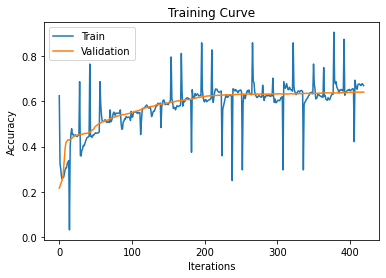

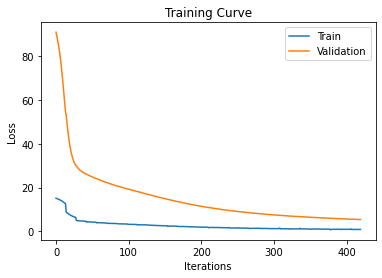

Final Training Accuracy: 0.6700536809815951
Final Validation Accuracy: 0.6410172925258665


In [59]:
use_cuda = True
model_init = AutoEncoder()

# Enable GPU usage
if use_cuda and torch.cuda.is_available():
  model_init.cuda()
  print('CUDA is available!')

print('Training ', end="")
train(model_init, train_loader, val_loader, num_epochs=30, batch_size=bs)

**ANSWER:**

### Part (d) [5 pt]

Tune your hyperparameters, training at least 4 different models (4 sets of hyperparameters).

Do not include all your training curves. Instead, explain what hyperparameters
you tried, what their effect was, and what your thought process was as you 
chose the next set of hyperparameters to try.

**ANSWER:**

Note: For each model described below, hyperparameters that are not listed are the same as the initial model i.e. the model trained in part (c) unless otherwise mentioned.

<br>*Model #1:*
*  number of linear layers in encoder/decoder: 2
*  number of neurons in the linear layers: 51 in the first, 45 in the second

Increasing the number of neurons increased the complexity and capability of the model. Using these hyperparameters, the model displayed less overfitting to the training dataset - the training and validation learning curves diverged after a greater number of training iterations. However, since 51 and 45 neurons are still on the higher end of possible values, for the next set of hyperparameters, I decided to decrease the dimensions of the embedding space further.

<br>*Model #2:*
*  number of linear layers in encoder/decoder: 2
*  number of neurons in the linear layers: 45 in the first, 30 in the second

Setting the number of neurons in the two layers to the values above decreased the training and validation accuracies of the model (58.42% and 60.68%). Since decreasing the number of neurons effectively reduces the dimensionality of the input, it can be concluded that valuable information from the input was lost during this process. As a result, the model is weaker at predicting the value of the missing feature. For the next set of hyperparameters, I decided to target the spikes in the training accuracy and increased the batch size to ensure that they were not a result of optimizing a different loss function each time (consequence of a too-small batch size).

<br>*Model #3:*
*  batch size = 256
*  optimizer: SGD with momentum = 0.9

Increasing the batch size to 256 increased the validation accuracy to 65.09%. However, the validation loss was much higher compared to the previous models indicating the model was less certain of its predictions. Since the spikes in training accuracy remained, I tried swapping out the Adam optimizer with SGD, which does not perform adaptive learning. However, this did not result in more consistent performance. On the contrary, the model accuracies decreased while losses increased indicating lower model performance. Since the model was still overfitting to the training data after a certain number of iterations, I decided to revert back to the first set of hyperparameters (model #1) and decreased the number of training epochs to target overfitting.

<br>*Model 4:*
*  number of epochs = 15

Decreasing the number of training iterations effectively stopped the model from overtraining. There was almost no sign of overfitting to the training set, and the final validation accuracy increased to 67.26%. The training curves for the final set of hyperparameters is shown in the code block below.

CUDA is available!
Training ...............

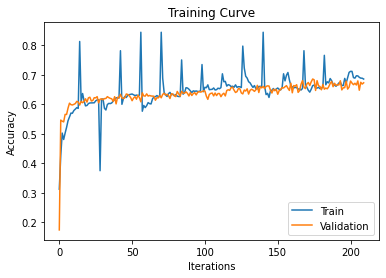

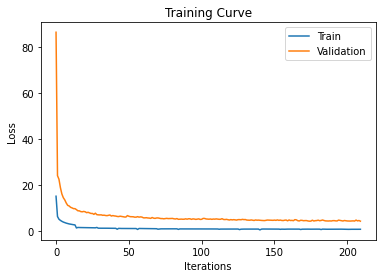

Final Training Accuracy: 0.685295245398773
Final Validation Accuracy: 0.6725634903407858


In [46]:
use_cuda = True
model = AutoEncoder()

# Enable GPU usage
if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!')

print('Training ', end="")
train(model, train_loader, val_loader, num_epochs=15, learning_rate=0.01 , batch_size=bs)

## Part 4. Testing [12 pt]

### Part (a) [2 pt]

Compute and report the test accuracy.

In [47]:
# ANSWER:

# Calculate the test accuracy using the get_accuracy function on the test dataset

test_acc, test_loss = get_accuracy(model, test_loader, criterion=nn.MSELoss())

# Report the calculated test accuracy
print("Model Test Accuracy: {}%".format(round(test_acc * 100, 2)))

Model Test Accuracy: 68.0%


### Part (b) [4 pt]

Based on the test accuracy alone, it is difficult to assess whether our model
is actually performing well. We don't know whether a high accuracy is due to
the simplicity of the problem, or if a poor accuracy is a result of the inherent
difficulty of the problem.

It is therefore very important to be able to compare our model to at least one
alternative. In particular, we consider a simple **baseline**
model that is not very computationally expensive. Our neural network
should at least outperform this baseline model. If our network is not much
better than the baseline, then it is not doing well.

For our data imputation problem, consider the following baseline model:
to predict a missing feature, the baseline model will look at the **most common value** of the feature in the training set. 

For example, if the feature "marriage" is missing, then this model's prediction will be the most common value for "marriage" in the training set, which happens to be "Married-civ-spouse".

What would be the test accuracy of this baseline model?


**ANSWER:**

In [48]:
# Function to find the most common value for a feature in a given dataset

def most_common_value(train_set):
  # Create a numpy array to hold a "one-hot encoding" 
  np_onehot = np.zeros(train_set.shape[1])
  
  # Iterate through the training set
  for rec in train_set:
    
    # For each possible value for a feature, add up the number of records that
    # are hot-encoded for that value, and store the result in np_onehot. For
    # example, if there are 3 records in the training set with 2 of them having
    # showing 'marriage_Divorced' and one of them showing 'marriage_Separated', 
    # np_onehot would have '2' in the column for 'marriage_Divorced' and '1' in 
    # the column for 'marriage_Separated'.
    for each_val in range(0, len(rec)):
      np_onehot[each_val] += rec[each_val]

    # Determine the categorical feature values of the new 'record'. These are
    # the most common values for all features in the training set.
  return get_features(np_onehot)

In [49]:
# Function to calculate accuracy of the baseline model. Inputs are the dataloader
# and a dict of values that the baseline model will predict for each feature

def get_baseline_accuracy(values_to_predict, data_loader):  
  # Counters to hold the correctly-predicted and total number of items in mini-batch 
  acc = 0
  total = 0

  for col in catcols:
    for item in data_loader: # minibatches
      inp = item.detach().numpy()
      
      for i in range(inp.shape[0]): # record in minibatch
        # Calculate the accuracy
        acc += int(values_to_predict[col] == get_feature(inp[i], col))
        total += 1
  
  # Return the accuracy of the model
  return acc / total

In [50]:
# Create a dict to hold the values that will be predicted by the baseline model
# for each feature
baseline_model_predictions = most_common_value(datanp[indices[:train_split]])

# Calculate the test accuracy of the baseline model using above function
baseline_test_acc = get_baseline_accuracy(baseline_model_predictions, test_loader)

# Report the calculated test accuracy
print("Baseline Model Test Accuracy: {}%".format(round(baseline_test_acc * 100, 2)))

Baseline Model Test Accuracy: 45.68%


### Part (c) [1 pt]

How does your test accuracy from part (a) compared to your basline test accuracy in part (b)?

**ANSWER:**

The test accuracy from part (a) is much higher than the baseline test accuracy seen above in part (b) i.e. 68.0% vs. 45.68%. This indicates that our neural network is performing relatively well.

### Part (d) [1 pt]

Look at the first item in your test data. 
Do you think it is reasonable for a human
to be able to guess this person's education level
based on their other features? Explain.

**ANSWER:**

As seen in the code block below, the first person in the test dataset is female, has never been married and works in transport-moving among other things. However, it is not reasonable to expect a human to guess their education level based on the data provided. This is because the categorical features contained in the test dataset i.e. marriage, occupation, etc. do not have an apparent relationsip to education level.

In [51]:
# Categorical feature values for the first item in the test dataset
get_features(datanp[indices[val_split]])

{'edu': '11th',
 'marriage': 'Never-married',
 'occupation': 'Transport-moving',
 'relationship': 'Own-child',
 'sex': 'Female',
 'work': 'Private'}

### Part (e) [2 pt]

What is your model's prediction of this person's education
level, given their other features?


**ANSWER:**

In [52]:
# Convert the numpy array into a tensor
first_item = torch.from_numpy(datanp[indices[val_split:val_split + 1]])

# Determine the model's prediction after zeroing out the values for education
model_output = model(zero_out_feature(first_item, 'edu')[0].cuda())

# Report the model's prediction
model_pred = get_feature(model_output[0], 'edu')
print("Model's prediction of education level:", model_pred)

Model's prediction of education level: HS-grad


### Part (f) [2 pt]

What is the baseline model's prediction
of this person's education level?

**ANSWER:**

In [53]:
# Report the baseline model's prediction
baseline_model_pred = baseline_model_predictions['edu']
print("Baseline model's prediction of education level:", baseline_model_pred)

Baseline model's prediction of education level: HS-grad
